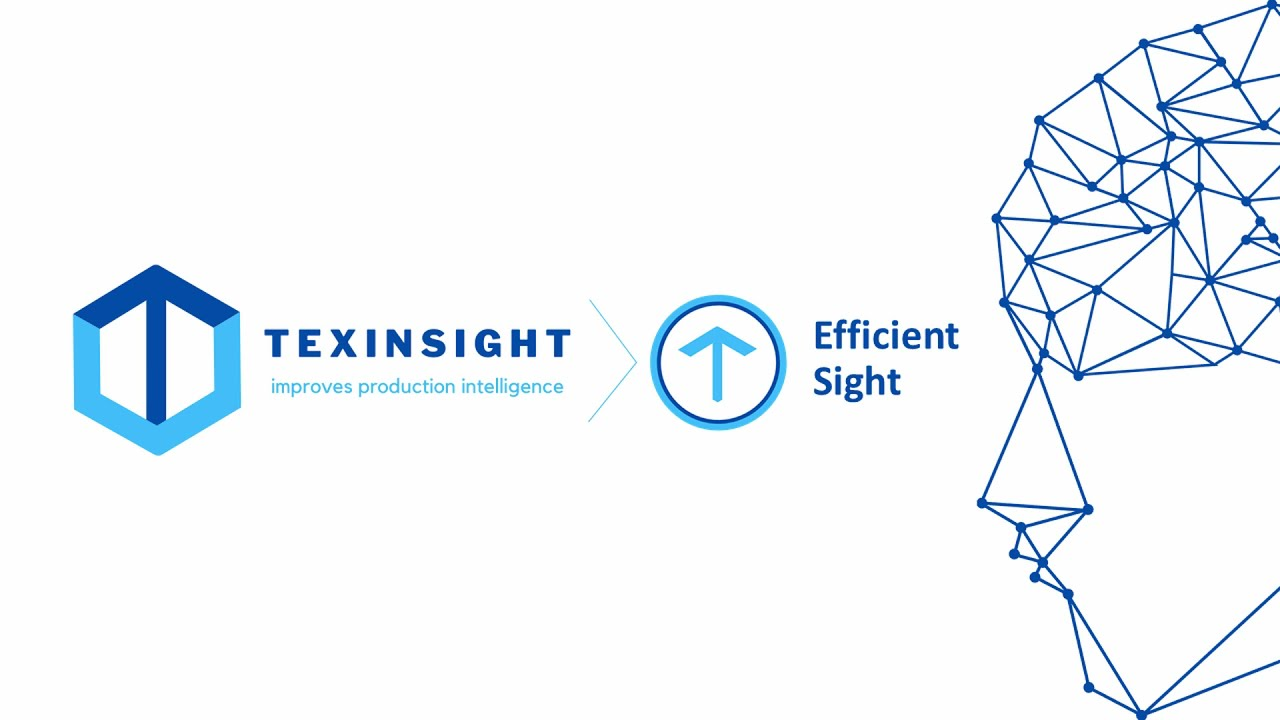


# SENTIMENT ANALYSIS

* Bu çalışmada amacımız müşteri uzun bi metin yüklediğinde yüzde kaç olumlu veya olumsuz olduğunu hesaplayıp müşteriye sunmak
- Burada BERT Algoritmasını kullanarak ilerleyeceğiz.
- Bert hakkında bilgi almak için. [https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270]

In [1]:
!pip install transformers
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertModel
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df = pd.read_csv("../input/sentiment/train.tsv", sep='\t')
df.head()                                                   # Phrase: Filmlerden alınan ifadeler

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
df['Sentiment'].value_counts()       # Etiketlerin amlamları

'''
The sentiment labels are:

0 - negative
1 - somewhat negative                                       
2 - neutral                               
3 - somewhat positive
4 - positive
'''

'\nThe sentiment labels are:\n\n0 - negative\n1 - somewhat negative                                       \n2 - neutral                               \n3 - somewhat positive\n4 - positive\n'

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')      

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

 - Maskeli dil modelleme (MLM): Bir cümle alarak, model girdideki kelimelerin %15'ini rastgele maskeler, ardından tüm maskelenmiş cümleyi model üzerinden çalıştırır ve maskelenmiş kelimeleri tahmin etmesi gerekir. Bu, genellikle kelimeleri birbiri ardına gören geleneksel tekrarlayan sinir ağlarından (RNN'ler)  veya gelecekteki belirteçleri dahili olarak maskeleyen GPT gibi otoregresif modellerden farklıdır. 
 - Daha fazla bilgi için [https://huggingface.co/docs/transformers/model_doc/bert]

In [5]:
# Burada BERT Tokenizer Sözcükleri ya tam biçimlere (örneğin, bir sözcük bir simge haline gelir) 
# ya da bir sözcüğün birden çok simgeye bölünebileceği sözcük parçalarına bölerek çalışır.
token = tokenizer.encode_plus(
    df['Phrase'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)


2022-02-09 16:56:10.555059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 16:56:10.556080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 16:56:10.556810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 16:56:10.559267: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
X_input_ids = np.zeros((len(df), 256))  #Giriş Cümleleri
X_attn_masks = np.zeros((len(df), 256)) # Maskelenen cümleler
print(X_input_ids.shape)
print(X_attn_masks.shape)

(156060, 256)
(156060, 256)


In [7]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Phrase'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length',                            # Burada fonksiyonu kurup veriye işliyoruz
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

- Düşük ek yüküne ek olarak, tqdm kalan süreyi tahmin etmek ve gereksiz yineleme görüntülerini atlamak için akıllı algoritmalar kullanır, bu da çoğu durumda ihmal edilebilir bir ek yük sağlar.
- Daha fazla bilgi için [https://tqdm.github.io/]

In [8]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)
labels = np.zeros((len(df), 5))
labels.shape

0it [00:00, ?it/s]

(156060, 5)

In [9]:
labels[np.arange(len(df)), df['Sentiment'].values] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [10]:
#tensorflow veri kümesi yardımcı programını kullanarak bir veri hattı oluşturma, kolay yükleme için veri yığınları oluşturur.
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data
dataset

<TensorSliceDataset shapes: ((256,), (256,), (5,)), types: (tf.float64, tf.float64, tf.float64)>

In [11]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [12]:
dataset = dataset.map(SentimentDatasetMapFunction) # tensorflow veri kümesi için gerekli biçime dönüştürme 
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size ayarlama
#Burada kendi bilgisayarınızın GPU'sunu kullanacaksanız ona göre batch size vermeniz gerekiyor.
#Kaggle'da haftalık 30 saat, Colab'ta ise günlük GPU' kullanım hakları tanınıyor.

In [13]:
p = 0.8
train_size = int((len(df)//16)*p) 
# Her 16 part veri için len(df)//16 numunemiz olacak, bunun %80'ini tren için alınıyor

In [14]:
train_size

7802

In [15]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [16]:
model = TFBertModel.from_pretrained('bert-base-cased') #önceden eğitilmiş bert temel modeli

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
# input_ids ve attn_masks için 2 giriş katmanı tanımlama 
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> aktivasyon katmanı (3D), 1 -> havuzlanmış çıktı katmanı (2D) 
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(intermediate_layer) 

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
intermediate_layer (Dense)      (None, 512)          393728      bert[0][1]                   

In [18]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [19]:
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [20]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2)

Epoch 1/2


2022-02-09 16:58:18.298350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


7802/7802 [==============================] - 4099s 524ms/step - loss: 0.7866 - accuracy: 0.6723 - val_loss: 0.7733 - val_accuracy: 0.6777
Epoch 2/2
7802/7802 [==============================] - 4087s 524ms/step - loss: 0.6694 - accuracy: 0.7203 - val_loss: 0.7423 - val_accuracy: 0.6866


In [21]:
sentiment_model.save('sentiment_model')

2022-02-09 19:15:09.325808: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
sentiment_model = tf.keras.models.load_model('sentiment_model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['Negative', 'A bit Negative', 'Neutral', 'A bit positive', 'Positive']):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

# SENTIMENT ANALYSIS TEST

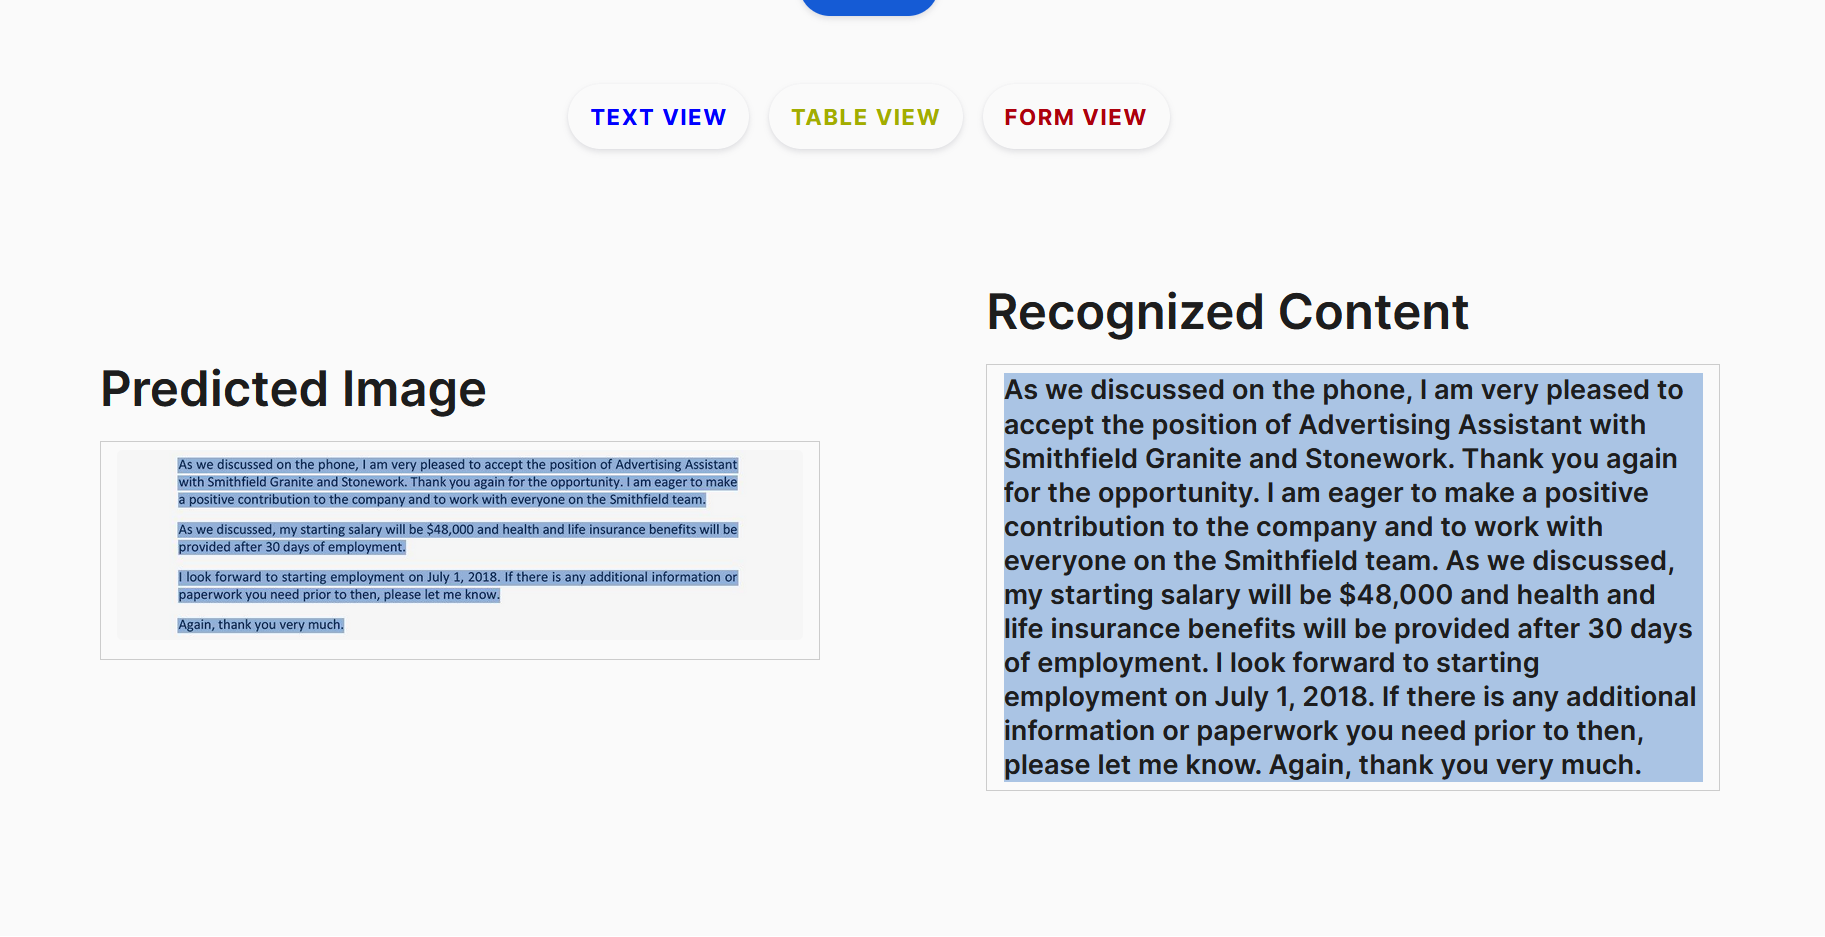

In [23]:
raw_text = "As we discussed on the phone, I am very pleased to accept the position of Advertising Assistant with Smithfield Granite and Stonework. Thank you again for the opportunity. I am eager to make a positive contribution to the company and to work with everyone on the Smithfield team. As we discussed, my starting salary will be $48,000 and health and life insurance benefits will be provided after 30 days of employment. I look forward to starting employment on July 1, 2018. If there is any additional information or paperwork you need prior to then, please let me know. Again, thank you very much."

text_tokenize = sent_tokenize(raw_text)

processed_text= []

score ={"Negative" : [],
       "A bit Negative": [],
       "Neutral": [],
       "A bit positive": [],
        "Positive": [] }

for i in range(0, len(text_tokenize)):
    modeled_text=  prepare_data(text_tokenize[i], tokenizer)
    result = make_prediction(sentiment_model, processed_data=modeled_text)
    processed_text.append(result)
    
    print(f"-Sentence: {text_tokenize[i]}\n Predicted Sentiment: {processed_text[i]}")
    
    if processed_text[i] == "Negative":
        score["Negative"].append(1)
    elif processed_text[i] == "A bit Negative":
        score["A bit Negative"].append(1)
    elif processed_text[i] == "Neutral":
        score["Neutral"].append(1)
    elif processed_text[i] == "A bit positive":
        score["A bit positive"].append(1)
    elif processed_text[i] == "Positive":
        score["Positive"].append(1)
        
    percn =(100/((len(score["Negative"] ))+ (len(score["A bit Negative"]))+ ( len(score["Neutral"])) + (len(score["A bit positive"]))+  (len(score["Positive"]))))
    
    
print(50*"-")
print("Negative: %", len(score["Negative"])*(percn))
print("A bit Negative: %", len(score["A bit Negative"])*(percn))
print("Neutral: %", len(score["Neutral"])*(percn))
print("A bit positive %:", len(score["A bit positive"])*(percn))
print("Positive: %", len(score["Positive"])*(percn))
   




-Sentence: As we discussed on the phone, I am very pleased to accept the position of Advertising Assistant with Smithfield Granite and Stonework.
 Predicted Sentiment: A bit positive
-Sentence: Thank you again for the opportunity.
 Predicted Sentiment: A bit positive
-Sentence: I am eager to make a positive contribution to the company and to work with everyone on the Smithfield team.
 Predicted Sentiment: A bit positive
-Sentence: As we discussed, my starting salary will be $48,000 and health and life insurance benefits will be provided after 30 days of employment.
 Predicted Sentiment: Neutral
-Sentence: I look forward to starting employment on July 1, 2018.
 Predicted Sentiment: Neutral
-Sentence: If there is any additional information or paperwork you need prior to then, please let me know.
 Predicted Sentiment: Neutral
-Sentence: Again, thank you very much.
 Predicted Sentiment: A bit positive
--------------------------------------------------
Negative: % 0.0
A bit Negative: % 0.0
